#**Практическое задание №1**

В настоящее время методы глубокого обучения показывают высокие достижения в классификации, сегментации и анализе биомедицинских изображений, включая гистологические изображения.

В данном исследовании основное внимание уделяется задаче классификации отдельных участков гистологических тканей.

###Подготовка

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import os
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

<font color="red">Замечание:</font> Пришлось внести изменение в класс Dataset, так как в входе проверки класса, столкнулся с проблемой - Access denied with the following error: Loading Dataset train_small from npz.

Поэтому, возможно если Вы столкнулись с той же проблемой - раскоментируйте блок кода ниже и закоментируйте другой. Оба варианта работают исправно.

> *Пожалуйста, не забудьте что нужно указать другой путь до набора данных. У меня находится в папке My Drive/Colab Notebooks*



In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False

        # Uncomment. If you have got rid of the problem. "Don't forget to comment below the block of code."
        ''' url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz') '''

        # Get the path to the current directory where the trained date set is located
        current_directory = '/content/drive/My Drive/Colab Notebooks'
        file_path = os.path.join(current_directory, f"{name}.npz")
        # Load the data from the file
        np_obj = np.load(file_path)

        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. Этот фрагмент кода не несет никакой информационной ценности, а лишь предназначен для проверки корректности выполнения класса Dataset."

Done. Dataset train_small consists of 7200 images.

Got numpy array of shape (224, 224, 3), and label with code 0.
Label code corresponds to ADI class.


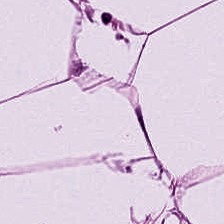

In [8]:
d_train_tiny = Dataset('train_small')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [6]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.


In [7]:
class Model:

    def __init__(self, input_shape=(224, 224, 3), num_classes=9):
        self.model = self.build_model(input_shape, num_classes)

    def build_model(self, input_shape, num_classes):
        #LBL13
        base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)
        model = Sequential()
        model.add(base_model)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(num_classes, activation='softmax'))
        return model

    def save(self, name: str):
        self.model.save(f'{name}.h5')

    def load(self, name: str):
        DATASETS_LINKS = {
            'best_final': '1-7AICbd8zpHrSZHwcstv8DqZa4TEixlg',
            'best_small':'1-1hmjHOaxJ29SHmbs2Pf8zLl4jy4SaBB',
            'best_tiny': '1qb9BK5TAqJak9QlRTrsKaM7IAgT6Lgm-'
        }
        link = f"https://drive.google.com/uc?export=download&id={DATASETS_LINKS.get(name, '')}"
        gdown.download(link, f'{name}.h5', quiet=False)
        self.model.load_weights(f'{name}.h5')

    def train(self, dataset: Dataset, epochs=10, batch_size=32):
        self.model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(dataset.images, dataset.labels, epochs=epochs, batch_size=batch_size)

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for i in tqdm(range(n)):
            img, label = dataset.image_with_label(i)
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        prediction = self.model.predict(np.expand_dims(img, axis=0))[0]
        return np.argmax(prediction)

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже.

In [ ]:
model = Model()

####Обучение на *train_tiny*

In [ ]:
d_train_tiny = Dataset('train_tiny')
model.train(d_train_tiny)
#LBL3
model.save('/content/drive/My Drive/Colab Notebooks/best_tiny')

#LBL5

Done. Dataset train_tiny consists of 900 images.
Epoch 1/10
29/29 [==============================] - 88s 486ms/step - loss: 1.1205 - accuracy: 0.6444
Epoch 2/10
29/29 [==============================] - 13s 441ms/step - loss: 0.7243 - accuracy: 0.7611
Epoch 3/10
29/29 [==============================] - 13s 441ms/step - loss: 0.7540 - accuracy: 0.7678
Epoch 4/10
29/29 [==============================] - 13s 447ms/step - loss: 0.6919 - accuracy: 0.7844
Epoch 5/10
29/29 [==============================] - 13s 448ms/step - loss: 0.5348 - accuracy: 0.8289
Epoch 6/10
29/29 [==============================] - 13s 451ms/step - loss: 0.4145 - accuracy: 0.8667
Epoch 7/10
29/29 [==============================] - 13s 454ms/step - loss: 0.3553 - accuracy: 0.8911
Epoch 8/10
29/29 [==============================] - 13s 458ms/step - loss: 0.3339 - accuracy: 0.8967
Epoch 9/10
29/29 [==============================] - 14s 469ms/step - loss: 0.2664 - accuracy: 0.8978
Epoch 10/10
29/29 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


####Обучение на *train_small*

In [ ]:
#LBL4
d_train_small = Dataset('train_small')
model.load('/content/drive/My Drive/Colab Notebooks/best_tiny')  # Loading the weights from the previous step
model.train(d_train_small)
model.save('/content/drive/My Drive/Colab Notebooks/best_small')

Done. Dataset train_small consists of 7200 images.
Epoch 1/10
225/225 [==============================] - 164s 465ms/step - loss: 0.4982 - accuracy: 0.8431
Epoch 2/10
225/225 [==============================] - 107s 476ms/step - loss: 0.2848 - accuracy: 0.9078
Epoch 3/10
225/225 [==============================] - 109s 483ms/step - loss: 0.2175 - accuracy: 0.9267
Epoch 4/10
225/225 [==============================] - 109s 485ms/step - loss: 0.1525 - accuracy: 0.9476
Epoch 5/10
225/225 [==============================] - 111s 491ms/step - loss: 0.1421 - accuracy: 0.9526
Epoch 6/10
225/225 [==============================] - 110s 490ms/step - loss: 0.1101 - accuracy: 0.9611
Epoch 7/10
225/225 [==============================] - 109s 487ms/step - loss: 0.0992 - accuracy: 0.9654
Epoch 8/10
225/225 [==============================] - 109s 486ms/step - loss: 0.1017 - accuracy: 0.9657
Epoch 9/10
225/225 [==============================] - 109s 486ms/step - loss: 0.0652 - accuracy: 0.9786
Epoch 10/10
2

####Обучение на *train*

In [ ]:
d_train = Dataset('train')
model.load('/content/drive/My Drive/Colab Notebooks/best_small') # Loading the weights from the previous step
model.train(d_train)
model.save('/content/drive/My Drive/Colab Notebooks/best_final')

Done. Dataset train consists of 18000 images.
Epoch 1/10
563/563 [==============================] - 345s 491ms/step - loss: 0.1405 - accuracy: 0.9539
Epoch 2/10
563/563 [==============================] - 275s 488ms/step - loss: 0.1123 - accuracy: 0.9634
Epoch 3/10
563/563 [==============================] - 275s 489ms/step - loss: 0.0849 - accuracy: 0.9716
Epoch 4/10
563/563 [==============================] - 275s 489ms/step - loss: 0.0837 - accuracy: 0.9739
Epoch 5/10
563/563 [==============================] - 275s 488ms/step - loss: 0.0575 - accuracy: 0.9806
Epoch 6/10
563/563 [==============================] - 275s 488ms/step - loss: 0.0561 - accuracy: 0.9816
Epoch 7/10
563/563 [==============================] - 275s 488ms/step - loss: 0.0499 - accuracy: 0.9829
Epoch 8/10
563/563 [==============================] - 275s 489ms/step - loss: 0.0423 - accuracy: 0.9851
Epoch 9/10
563/563 [==============================] - 275s 489ms/step - loss: 0.0353 - accuracy: 0.9879
Epoch 10/10
563/56

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


####Пример тестирования модели на части набора данных:

In [ ]:
d_test = Dataset('test')
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

Done. Dataset test consists of 4500 images.


  0%|          | 0/450 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
metrics for 10% of test:
	 accuracy 0.9533:
	 balanced accuracy 0.9533:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


####Пример тестирования модели на полном наборе данных:

In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/4500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step
metrics for test:
	 accuracy 0.7876:
	 balanced accuracy 0.7876:


### Тестирование модели на других наборах данных

Модель должна поддерживать тестирование на других наборах данных. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

In [8]:
final_model = Model()
final_model.load('best_final')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

171317808/171317808 [==============================] - 2s 0us/step


Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1-7AICbd8zpHrSZHwcstv8DqZa4TEixlg
From (redirected): https://drive.google.com/uc?export=download&id=1-7AICbd8zpHrSZHwcstv8DqZa4TEixlg&confirm=t&uuid=e0dcd667-24b5-4617-8d89-9aafc1717522
To: /content/best_final.h5
100%|██████████| 512M/512M [00:03<00:00, 134MB/s]


Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

1/1 [==============================] - 0s 315ms/step
metrics for test-tiny:
	 accuracy 0.7556:
	 balanced accuracy 0.7556:


In [9]:
final_model = Model()
final_model.load('best_final')
d_test_tiny = Dataset('test_small')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-small')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1-7AICbd8zpHrSZHwcstv8DqZa4TEixlg
From (redirected): https://drive.google.com/uc?export=download&id=1-7AICbd8zpHrSZHwcstv8DqZa4TEixlg&confirm=t&uuid=7693b92f-bf5b-4c33-b913-ec1096e862c5
To: /content/best_final.h5
100%|██████████| 512M/512M [00:02<00:00, 226MB/s]


Done. Dataset test_small consists of 1800 images.


  0%|          | 0/1800 [00:00<?, ?it/s]

1/1 [==============================] - 1s 568ms/step
metrics for test-small:
	 accuracy 0.7950:
	 balanced accuracy 0.7950:


In [10]:
final_model = Model()
final_model.load('best_final')
d_test_tiny = Dataset('test')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1-7AICbd8zpHrSZHwcstv8DqZa4TEixlg
From (redirected): https://drive.google.com/uc?export=download&id=1-7AICbd8zpHrSZHwcstv8DqZa4TEixlg&confirm=t&uuid=f5510021-b6e5-4dd0-90e0-75e85bb8db59
To: /content/best_final.h5
100%|██████████| 512M/512M [00:02<00:00, 199MB/s]


Done. Dataset test consists of 4500 images.


  0%|          | 0/4500 [00:00<?, ?it/s]

1/1 [==============================] - 1s 550ms/step
metrics for test:
	 accuracy 0.7876:
	 balanced accuracy 0.7876:


####Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()